[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pol-is/notebooks/blob/master/020-PCA.ipynb)

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

plt.figure(figsize=(500, 500))
sns.set_context('poster')
sns.set_style('white')
sns.set(font_scale=.7)
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Import raw data && clean up

In [113]:
df = pd.read_csv('./bowlinggreen/participants-votes.csv',index_col='participant')
df_comments = pd.read_csv('./bowlinggreen/comments.csv',index_col='comment-id')

In [114]:
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

In [115]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`

## check for each row if the number of finite values >= cutoff
def select_rows(df, threshold=7):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]
    
df = select_rows(df)

In [116]:
metadata = df[metadata_fields]
vals = df[val_fields]

In [117]:
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)

In [118]:
vals = vals.sort_values("participant")

# PCA

In [119]:
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 
## X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca_object = PCA(n_components=20) ## pca is apparently different, it wants 
pca_object = pca_object.fit(vals.values.T) ## .T transposes the matrix (flips it)
pca_coordinates = pca_object.components_.T ## isolate the coordinates and flip so they're the same shape as the tsne output
print("Coordinates:", pca_coordinates[:1, :])
print("Explained variance:", pca_object.explained_variance_ratio_)

# binary matrix ... amount of info in any given cell in the matrix not a lot ... 
# if not capturing very much variance in first PCs, need to evaluate other methods

Coordinates: [[ 0.08101036  0.04187745  0.12627028  0.0183454   0.01050416  0.01555495
   0.00808749 -0.0549122   0.13544659  0.02893148  0.02405903 -0.05893715
   0.03412554 -0.04598104  0.07667953 -0.03675411 -0.02816823  0.07325858
  -0.10938974  0.08249868]]
Explained variance: [0.15656699 0.06836304 0.02902814 0.01977311 0.01733519 0.01418206
 0.01196541 0.01094178 0.01003893 0.00958142 0.00908063 0.00839864
 0.00794314 0.00739623 0.00710891 0.00702417 0.00684914 0.00663882
 0.00638707 0.00634221]


# Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial. 
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

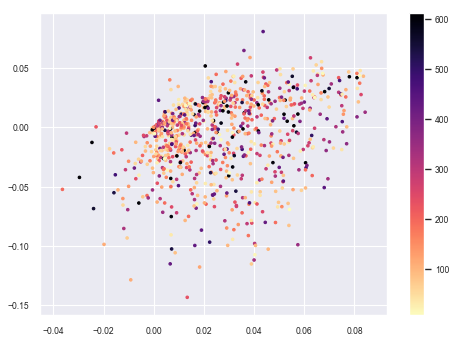

In [120]:
plt.figure(figsize=(7, 5), dpi=80)
plt.scatter(
    x=pca_coordinates[:,0], 
    y=pca_coordinates[:,1], 
    c=metadata['n-votes'], 
    cmap="magma_r",
    s=5
)
plt.colorbar()

# Color the PCA plot by comment voting patterns

In [121]:
# Color the PCA plot by comment ID
# 1 is agree, 0 is did not see or passed, -1 is disagreed

def c(commentid):
    plt.figure(figsize=(7, 5), dpi=80)
    plt.scatter(
        x=pca_coordinates[:,0], 
        y=pca_coordinates[:,1], 
        c=vals[str(commentid)],  #metadata['n-votes'], 
        cmap="RdYlBu",
        s=5
    )
    plt.colorbar()
    print(df_comments["comment-body"][commentid])

It is embarrassing that our city is the largest in the state not to have a fairness ordinance.


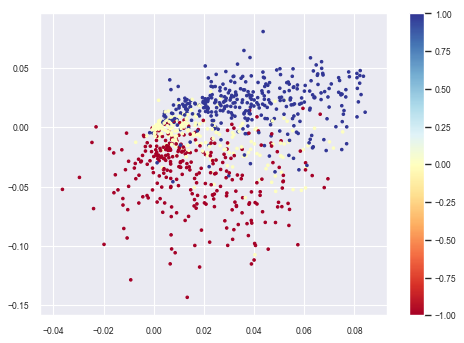

In [122]:
c(20)

A city should have the right to declare itself a sanctuary city.


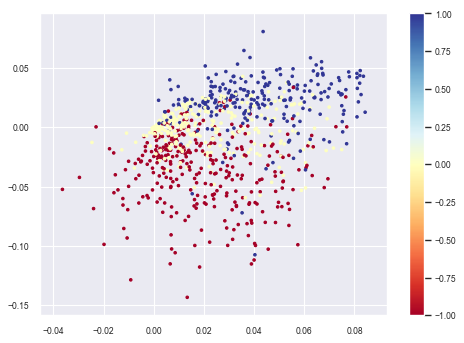

In [123]:
c(26)

LGBTQ fairness is far-left political idiocy.


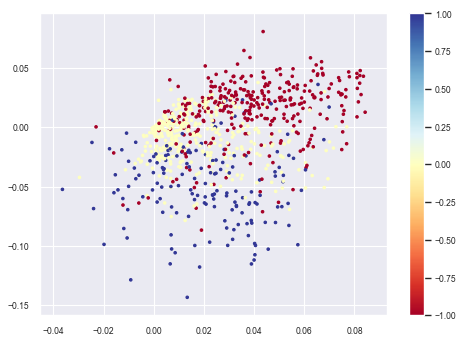

In [124]:
c(90)

All students in Warren county should have the best available education, not the Kentucky minimum, at all times.


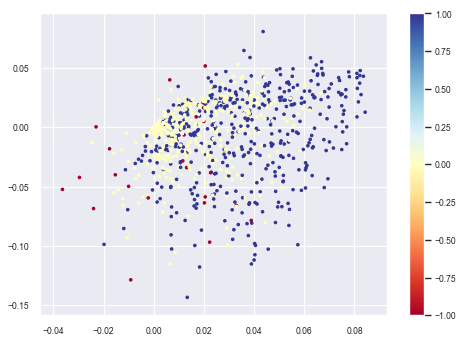

In [125]:
c(39)

Bowling Green needs more competitive cable rates.


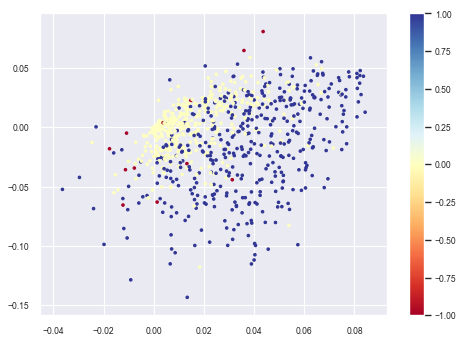

In [126]:
c(200)

Harsher sentences for drug users would help combat the opioid epidemic.


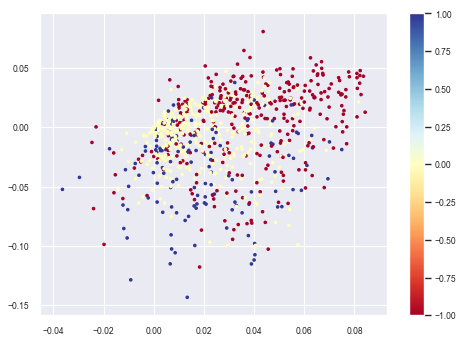

In [127]:
c(9)

We already have a lot of parks. And the libraries have become a hangout for the homeless.  Do something about that problem first


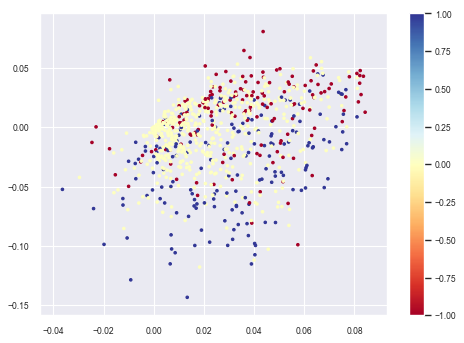

In [128]:
c(45)

Our local immigrant population has, overall, been a benefit to our city and county.


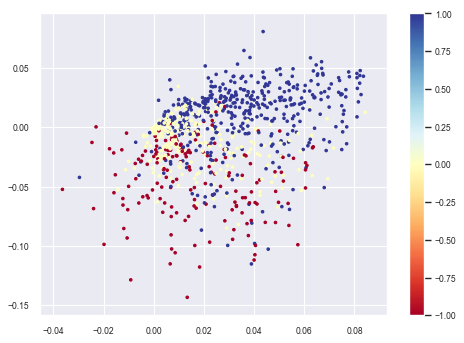

In [129]:
c(30)

We need an NBA team. I think we should put the arena where the airport is. Think about it.


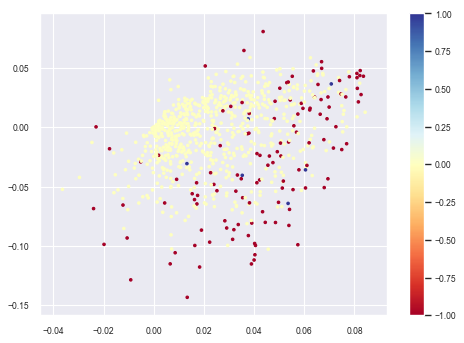

In [130]:
c(353)

Government should ignore criminal malfeasance/embezzlement of public funds by anyone if little or no funds can be recovered.


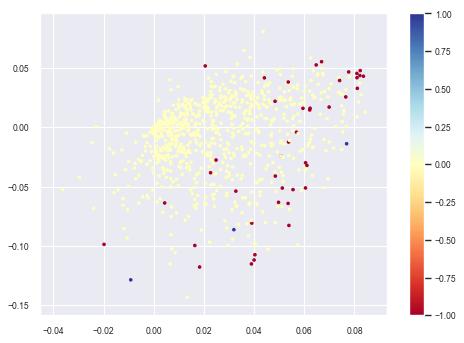

In [131]:
c(779)